# Pluto's Orbit, and Validating Kepler's Second Law

## Eriel Wiston and Alexandra Maycock

## Q: Is Kepler's Second Law satisfied when tested against Pluto's highly eccentric orbit?
Kepler's Second Law of Planetary Motion states that for each equivalent time division of an object's orbit, each sector swept out by the object, from the center of rotation, has an equal area. For a visual please see: https://kids.britannica.com/students/assembly/view/90830. For example, if a planet is revolving around the sun and a line is drawn from the planet to the sun on "day 0" of its orbit and "day 5" of its orbit, the area between those two radii and the path the planet traveled should be identical to the sector drawn in the same manner from "day 5" to "day 10". 

Our model seeks to validate this law by first modeling the orbit of Pluto and then dividing that orbit into sectors and estimating the area of the sectors using a triangle approximation. Pluto was chosen due to its highly eccentric orbit, which makes this priciple harder to visualize and thus in need of mathematical verification. 

----
## Method:
Preparing the notebook.

In [77]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [78]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

For this model, the sun is considered to remain at the origin on a rectangular plane. Below are the initial conditions, which initialize Pluto's radius and velocity at perihelion (the point at which its distance from the sun is smallest). All
other positions and velocities are initialized to 0, and thus pluto begins on the x axis.

In [79]:
r_0 = 4436.82e9 * m
v_0 = -6100 * m/s

init = State(x = r_0,
             y = 0 * m/s,
             vx = 0 * m / s,
             vy = v_0)

,values
x,4436820000000.0 meter
y,0.0 meter / second
vx,0.0 meter / second
vy,-6100.0 meter / second


Now, we make the system object, which contains Pluto's radius, the sun's radius, the combined radius of Pluto and the sun, the State object, the masses of Pluto and the sun, the start and end time, and the
gravitational constant.

In [80]:
r_pluto = 1187000 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                m2=0.01303e24 * kg,
                t_0=0 * s,
                t_end=7820000000 * s,
                slices = 2000)

,values
init,x 4436820000000.0 meter y 0.0 met...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
m2,1.303e+22 kilogram
t_0,0 second
t_end,7820000000 second
slices,2000


This function computes the force of gravity, using universal gravitation.

In [81]:
def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x, y, vx, vy = state
    unpack(system)
    r = Vector(x, y)
    v = Vector(vx, vy)
 
    force_mag = G * m1 * m2 / r.mag**2
    force = r.hat() * force_mag 
   # force = Vector(G*m1*m2/x**2, G*m1*m2/y**2)
    return force

In [82]:
#Testing the universal gravitation function
universal_gravitation(init, system)

<Quantity([8.78661872e+16 0.00000000e+00], 'newton')>

The slope function calculates velocity and acceleration for each time step in our orbit

In [83]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x, y, vx, vy = state
    unpack(system)    

    force_x, force_y = universal_gravitation(state, system)
    dxdt = vx
    dydt = vy
    dvxdt = -force_x / m2
    dvydt = -force_y / m2
    
    return dxdt, dydt, dvxdt, dvydt

In [84]:
#testing the slope function
slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(-6100.0, 'meter / second')>,
 <Quantity(-6.743375839653671e-06, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

Now to run the simulation of the orbit.

In [85]:
#Here, we test all the functions together

#defining the amount of time in each sector of the orbit
dt = (system.t_end - system.t_0)/ system.slices

#creating an array of times for the ODE solver to sun the simulation at. 
#Using this method ensures that data is present for the star and end times of each sector.
times = (linrange(system.t_0, system.t_end, dt))

#Run the simulation
results, details = run_ode_solver(system, slope_func, t_eval = times, method='RK23')

#It worked
details

,values
sol,None
t_events,[]
nfev,149
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


The position and velocites are retuned by this simulation.

In [86]:
#the first six time steps
results.head()

,x,y,vx,vy
0.0,4.436820e+12,0.000000e+00,0.000000,-6100.000000
3910000.0,4.436768e+12,-2.385091e+10,-26.366423,-6099.929126
7820000.0,4.436614e+12,-4.770126e+10,-52.731783,-6099.716470
11730000.0,4.436356e+12,-7.155051e+10,-79.095022,-6099.362067
15640000.0,4.435995e+12,-9.539809e+10,-105.455079,-6098.865974


We do not expect Pluto to collide with the sun in its regular orbit, so our final time should be a full year, which is how many seconds we started with

In [87]:
t_final = get_last_label(results) * s

<Quantity(7816090000.0, 'second')>

Here is the orbit plotted on the xy-plane.

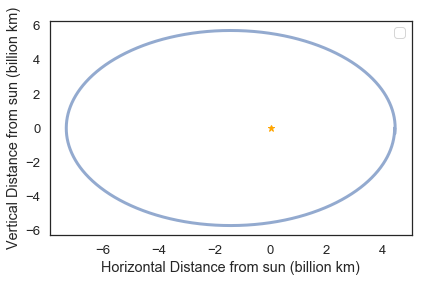

In [88]:
#Our results are scaled to Earth days
results.index /= 60 * 60 * 24

#And to billions of kilometers, and plotted
x = results.x / 1e12;
y = results.y /1e12;
plot(x, y)

#Look! The sun is an orange star! Isn't that neato?
plt.plot(0, 0, marker='*', markersize=7, color="orange")

decorate(xlabel='Horizontal Distance from sun (billion km)',
         ylabel='Vertical Distance from sun (billion km)')

Now that we have a representation of the orbit, we can divide it into secotors and calculate a the area of each one. We used trinangles to estimate this area as they are acruate eough estitamte of the area and use math that more directly uses the orbit data. THis avoids rounding and math errors.

In [90]:
# creating a state to caluclate and analyze the triangular estimations of the sectors of the orbit.

#start time of the sector
S = results.index[0]

#end time of the triangle
E = results.index[1]

#length of triangle side between sun and pluto's postion at the start time
a_vec = Vector(results.x[results.index[0]], results.y[results.index[0]])
A = a_vec.mag

#length of triangle side between sun and pluto's postion at the end time
b_vec = Vector(results.x[results.index[1]], results.y[results.index[1]])
B = b_vec.mag

#Length of triangle side between pluto's position at the start and end time
C = sqrt((results.x[results.index[1]]-results.x[results.index[0]])**2 +(results.y[results.index[1]]-results.y[results.index[0]])**2 )

#Calculating the semiperimeter of the triangle formed by A, B, and C.
SP = (A+B+C)/2

#Caluclating the area of the triangle using Heron's formula.
area = sqrt(SP * (SP - A) * (SP - B) * (SP - C))

#Creating state object
state= State(S=S, E=E, A=A, B=B, C=C, SP=SP, area=area)

,values
S,0
E,45.2546
A,4436820000000.0 dimensionless
B,4436832562882.295 dimensionless
C,2.3851e+10
SP,4448751763136.124 dimensionless
area,5.291109213451941e+22 dimensionless


The in intal sector infomation is fed into this fuction and the remaining sectors are determined and their details calculated and retunred in a table.

In [97]:
def area_of_sector(results,system,state):
    """Divide the orbit into sectors and create a triangle that estimetes
    the area of each sector.
    
    results = postion and velocity infomation for a single complete orbit
    system = the sytem used to retun results and containg the nuber of sectors
    state = State object to old sector and triangle estimate information
    
    returns: a time frame with the presctibed information for each sector tiangle estimation.
    """
    unpack(system)
    
    dt = (t_end-t_0)/slices
      
    frame = TimeFrame(columns = state.index)
    frame.row[1] = state 
    
    for t in linrange (1, slices):
        frame.row[t+1] = one_sector(frame.row[t], t, system, results)
        
    return frame
    

The "update function" for the sectors which comptues a single row, an single sector of the orbit.

In [100]:
def one_sector(state, t , system, results):
    """Comutes the start time, end time, length of the three sides of the triangle estimation, the semiperimeter of the
    trinagle, and the area of the triangle.
    
    state = the state being used to stoe sector information
    t = a vairable passed by the area of a sector function, the sector being computed.
    sytem = the sytem bject used to run the orbit simuoaion and containing the number of secotrs.
    results = the postion and velocity data of an orbit
    
    retuns: specification of each sector.
    """
    s, e, a, b, c, sp, area = state
    unpack(system)
    
    #establish the time steps used in the orbit simulation 
    dt = (t_end-t_0)/slices/UNITS.s
    
    #record the times of the new sector
    news = e
    newe = news + dt
    
    #Take the magnitude of a vector from Pluto's postion at the start time and use it's magnitude as a side of the triangle.
    a_vec = Vector(results.x[results.index[t-1]], results.y[results.index[t-1]])       
    newa = a_vec.mag
    
    #Take the magnitude of a vector from Pluto's postion at the end time and use it's magnitude as a side of the triangle.
    b_vec = Vector(results.x[results.index[t]], results.y[results.index[t]])
    newb = b_vec.mag 

    #calclate the distance between the points used for the other two sides of the tiangle to define the third.
    newc = sqrt((results.x[results.index[t]]-results.x[results.index[t-1]])**2 +(results.y[results.index[t]]-results.y[results.index[t-1]])**2 )
    
    #calculate semiperimeter and area
    newsp = (newa + newb + newc)/2
    newarea = sqrt(newsp * (newsp - newa) * (newsp - newb) * (newsp - newc))
    
    return State (S=news, E=newe, A=newa, B=newb, C=newc, SP=newsp, area=newarea)
    
    
    

---
## Results:
The simulation of the orbit has been broken down into sectors and their areas, here the returned information is presented.

The information for the first 6 sectors is shown. There are 2000 in total.

In [98]:
numbs = area_of_sector(results, system, state)
numbs.head()

,S,E,A,B,C,SP,area
1,0,45.2546,4436820000000.0 dimensionless,4436832562882.295 dimensionless,2.385096e+10,4448751763136.124 dimensionless,5.291109213451941e+22 dimensionless
2,45.2546,3910045.2546296297 dimensionless,4436820000000.0 dimensionless,4436832562882.295 dimensionless,2.385096e+10,4448751763136.124 dimensionless,5.291109213451941e+22 dimensionless
3,3910045.2546296297 dimensionless,7820045.25462963 dimensionless,4436832562882.295 dimensionless,4436870269641.3 dimensionless,2.385086e+10,4448776843943.656 dimensionless,5.291109345233894e+22 dimensionless
4,7820045.25462963 dimensionless,11730045.25462963 dimensionless,4436870269641.3 dimensionless,4436933119957.921 dimensionless,2.385064e+10,4448827014049.048 dimensionless,5.291109436062589e+22 dimensionless
5,11730045.25462963 dimensionless,15640045.25462963 dimensionless,4436933119957.921 dimensionless,4437021101770.312 dimensionless,2.385031e+10,4448902267181.994 dimensionless,5.2911094505689865e+22 dimensionless


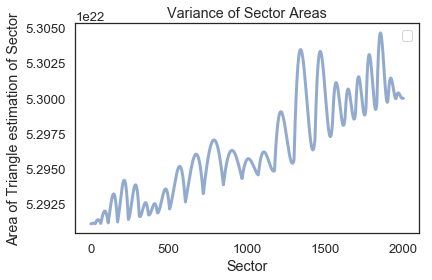

In [94]:
# Plotting the areas of each sector to compare them.
plot(numbs.area)

decorate(xlabel='Sector',
         ylabel='Area of Triangle estimation of Sector',
         title = 'Variance of Sector Areas')

In order to determine how similar the areas of each sector are, we determined the largest possible difference between the areas of two sectors, known as the range. This value is computed below.

In [95]:
large = numbs.area.max()
small = numbs.area.min()
range = large - small

<Quantity(1.3512186410959477e+20, 'dimensionless')>

This value, standing alone, seems quite large, standing at about 135 quintillion square meters, but taking into account that Pluto's distance from the sun at any point in time is trillions of meters away, the difference between areas may be relatively smaller than we think. In order to make sure, we calculate the approximate percent error of the sample of areas, taking the range and dividing it by the average sector area.

In [96]:
avg= sum(numbs.area)/len(numbs.area)
(large-small)/avg

<Quantity(0.002551190416655728, 'dimensionless')>

Now that we see the percent error is 0.00255, or about 0.255 percent, we are able to more easily tell that although the difference is large in number to our perception, it is not a statistically significant difference.

Because the difference is not statistically significant, we can reasonably conclude that Kepler's Second Law is correct for Pluto's orbit.

----
## Interpretation:

There were no significant failings of our model that impeded upon our success, but there were several sources of slight error along the way. One of these sources of error was our inexact computation of the areas of each sector; we used triangular approximations, rather than the true-to-form irregular elliptical sectors, to more easily calculate the orbital areas we needed. While this was far easier, both mathematically and computationally, this approximation did lead to round-off errors and the like. You'll notice in our final graph that the areas of the sectors trend upward: we attribute that behavior to this error, because as the orbit cycles through, the rounded ends of the orbit that we do not capture in our area calculation also vary in size. We cannot account for this change in our calculation, and so the orbital areas appear to get bigger while in reality the rounded areas we do not capture grow smaller.

The role of iteration in our modeling process was a continual one: several portions of our code depended on constant reworkings in order to eventually come up with an executable product. For instance, the functions in which we computed and outputted area were made via iterative processes, because we had initially attempted the more exact, yet far more difficult, calculation of the elliptical sectors, but when we found that to be too challenging, we quickly revised the function several times over.